 Load packages used for the project

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow

D:\Programfiles\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_PATH = '../bee_imgs/bee_imgs'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

In [3]:
os.listdir("D:/MIT-WPU/5th sem/AAI/Project/Dataset/bee_imgs/bee_imgs")

['.DS_Store',
 '001_043.png',
 '001_044.png',
 '001_046.png',
 '001_047.png',
 '001_050.png',
 '001_051.png',
 '001_054.png',
 '001_056.png',
 '001_078.png',
 '001_082.png',
 '001_083.png',
 '001_085.png',
 '001_091.png',
 '001_092.png',
 '001_093.png',
 '001_094.png',
 '001_095.png',
 '001_096.png',
 '001_097.png',
 '001_118.png',
 '001_120.png',
 '001_121.png',
 '001_122.png',
 '001_124.png',
 '001_126.png',
 '001_127.png',
 '001_131.png',
 '001_132.png',
 '001_133.png',
 '001_134.png',
 '001_135.png',
 '001_138.png',
 '001_140.png',
 '001_144.png',
 '001_145.png',
 '001_147.png',
 '001_149.png',
 '001_151.png',
 '001_152.png',
 '001_156.png',
 '001_159.png',
 '001_160.png',
 '001_163.png',
 '001_164.png',
 '001_167.png',
 '001_168.png',
 '001_169.png',
 '001_171.png',
 '001_172.png',
 '001_173.png',
 '002_022.png',
 '002_023.png',
 '002_024.png',
 '002_026.png',
 '002_030.png',
 '002_031.png',
 '002_033.png',
 '002_034.png',
 '002_035.png',
 '002_037.png',
 '002_044.png',
 '002_046.

In [4]:
honey_bee_df=pd.read_csv('D:/MIT-WPU/5th sem/AAI/Project/Dataset/bee_data.csv')
honey_bee_df.shape
honey_bee_df.sample(100).head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
2514,004_413.png,7/2/18,15:30,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
5129,033_073.png,8/21/18,9:30,"Des Moines, IA, USA",50315,Western honey bee,healthy,False,worker
2206,046_135.png,8/19/18,15:46,"Des Moines, IA, USA",50315,Carniolan honey bee,healthy,False,worker
799,030_399.png,8/17/18,17:50,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
114,017_064.png,8/6/18,13:21,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [5]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(honey_bee_df)

,Total,Percent
file,0,0.0
date,0,0.0
time,0,0.0
location,0,0.0
zip code,0,0.0
subspecies,0,0.0
health,0,0.0
pollen_carrying,0,0.0
caste,0,0.0


In [6]:
IMAGE_PATH = 'D:/MIT-WPU/5th sem/AAI/Project/Dataset/bee_imgs/bee_imgs'
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5173


In [7]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",579
2,30607,"Athens, Georgia, USA",472
3,50315,"Des Moines, IA, USA",973
4,70115,"New Orleans, LA, USA",170
5,77511,"Alvin, TX, USA",737
6,95070,"Saratoga, CA, USA",2000
7,95124,"San Jose, CA, USA",149


In [8]:
honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

In [9]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df['code'] = df['location'].map(lambda x: x.split(',', 2)[1])
df

,zip code,location,Images,code
0,3431,"Keene, NH, USA",92,NH
1,30607,"Athens, GA, USA",1051,GA
2,50315,"Des Moines, IA, USA",973,IA
3,70115,"New Orleans, LA, USA",170,LA
4,77511,"Alvin, TX, USA",737,TX
5,95070,"Saratoga, CA, USA",2000,CA
6,95124,"San Jose, CA, USA",149,CA


In [10]:
trace = go.Bar(
        x = df['location'],
        y = df['Images'],
        marker=dict(color="Tomato"),
        text=df['location']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per location',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-location')

In [11]:
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index
print(locations)

Index(['Alvin, TX, USA', 'Athens, GA, USA', 'Des Moines, IA, USA',
       'Keene, NH, USA', 'New Orleans, LA, USA', 'San Jose, CA, USA',
       'Saratoga, CA, USA'],
      dtype='object', name='location')


In [12]:
IMAGE_PATH = r'D:/MIT-WPU/5th sem/AAI/Project/Dataset/bee_imgs/bee_imgs/'

In [13]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

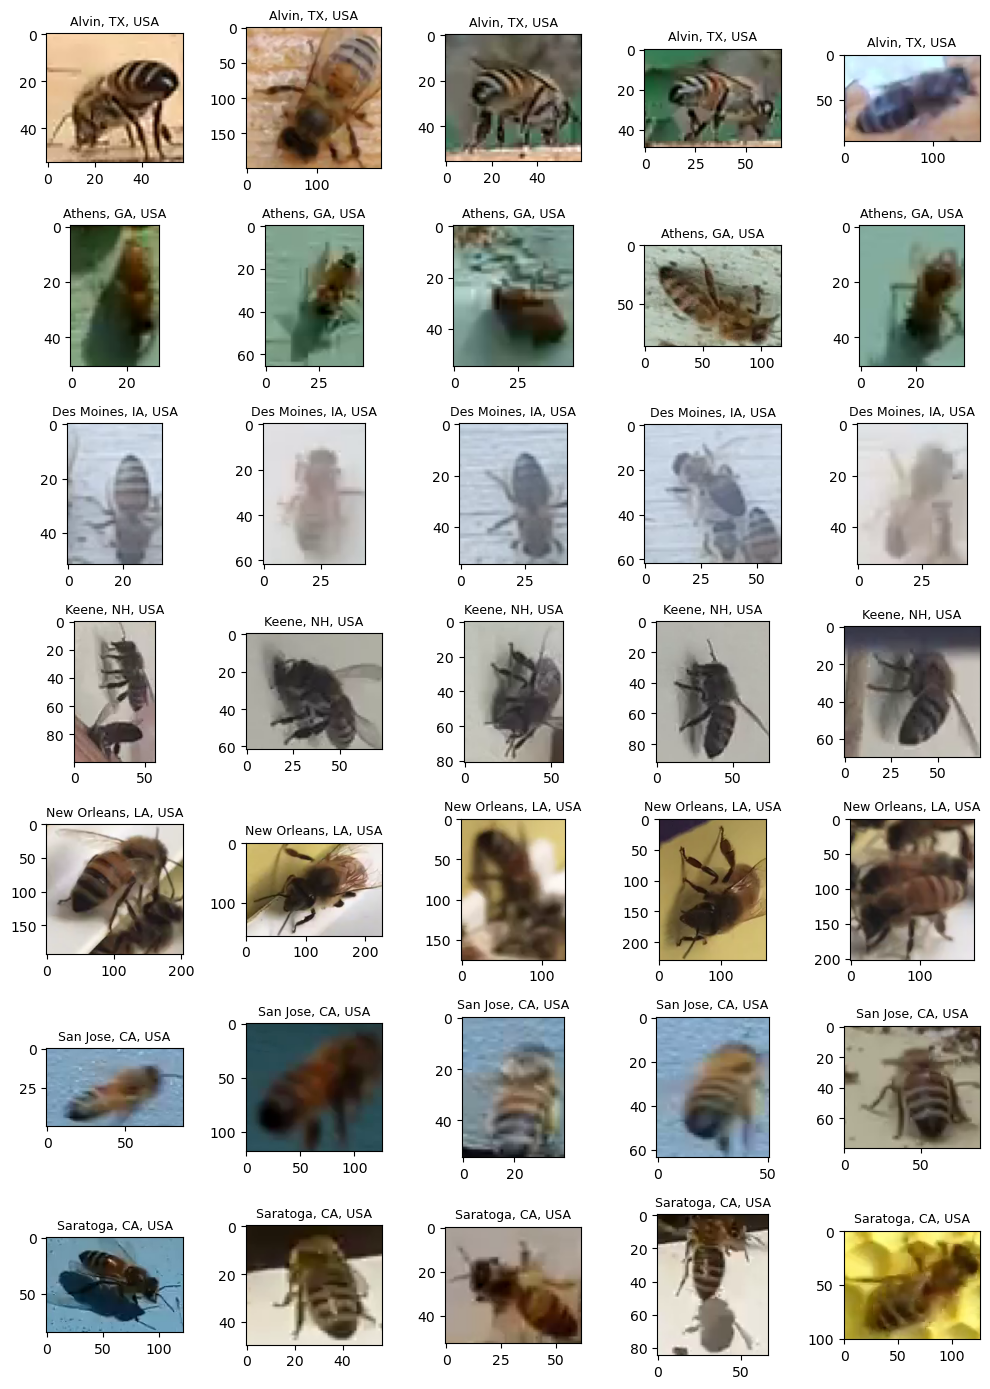

In [14]:
draw_category_images("location")

In [15]:
honey_bee_df['date_time'] = pd.to_datetime(honey_bee_df['date'] + ' ' + honey_bee_df['time'])
honey_bee_df["year"] = honey_bee_df['date_time'].dt.year
honey_bee_df["month"] = honey_bee_df['date_time'].dt.month
honey_bee_df["day"] = honey_bee_df['date_time'].dt.day
honey_bee_df["hour"] = honey_bee_df['date_time'].dt.hour
honey_bee_df["minute"] = honey_bee_df['date_time'].dt.minute

In [16]:
tmp = honey_bee_df.groupby(['date_time', 'hour'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
hover_text = []
for index, row in df.iterrows():
    hover_text.append(('Date/time: {}<br>'+
                      'Hour: {}<br>'+
                      'Location: {}<br>'+
                      'Images: {}').format(row['date_time'],
                                            row['hour'],
                                            row['location'],
                                            row['Images']))
df['hover_text'] = hover_text
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index
data = []
for location in locations:
    dfL = df[df['location']==location]
    trace = go.Scatter(
        x = dfL['date_time'],y = dfL['hour'],
        name=location,
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=0.2,
            size=dfL['Images'],
            line=dict(
                width=2
            ),),
        mode = "markers",
        text=dfL['hover_text'],
    )
    data.append(trace)
    
layout = dict(title = 'Number of bees images per date, approx. hour and location',
          xaxis = dict(title = 'Date', showticklabels=True), 
          yaxis = dict(title = 'Hour'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)

iplot(fig, filename='images-date_time')

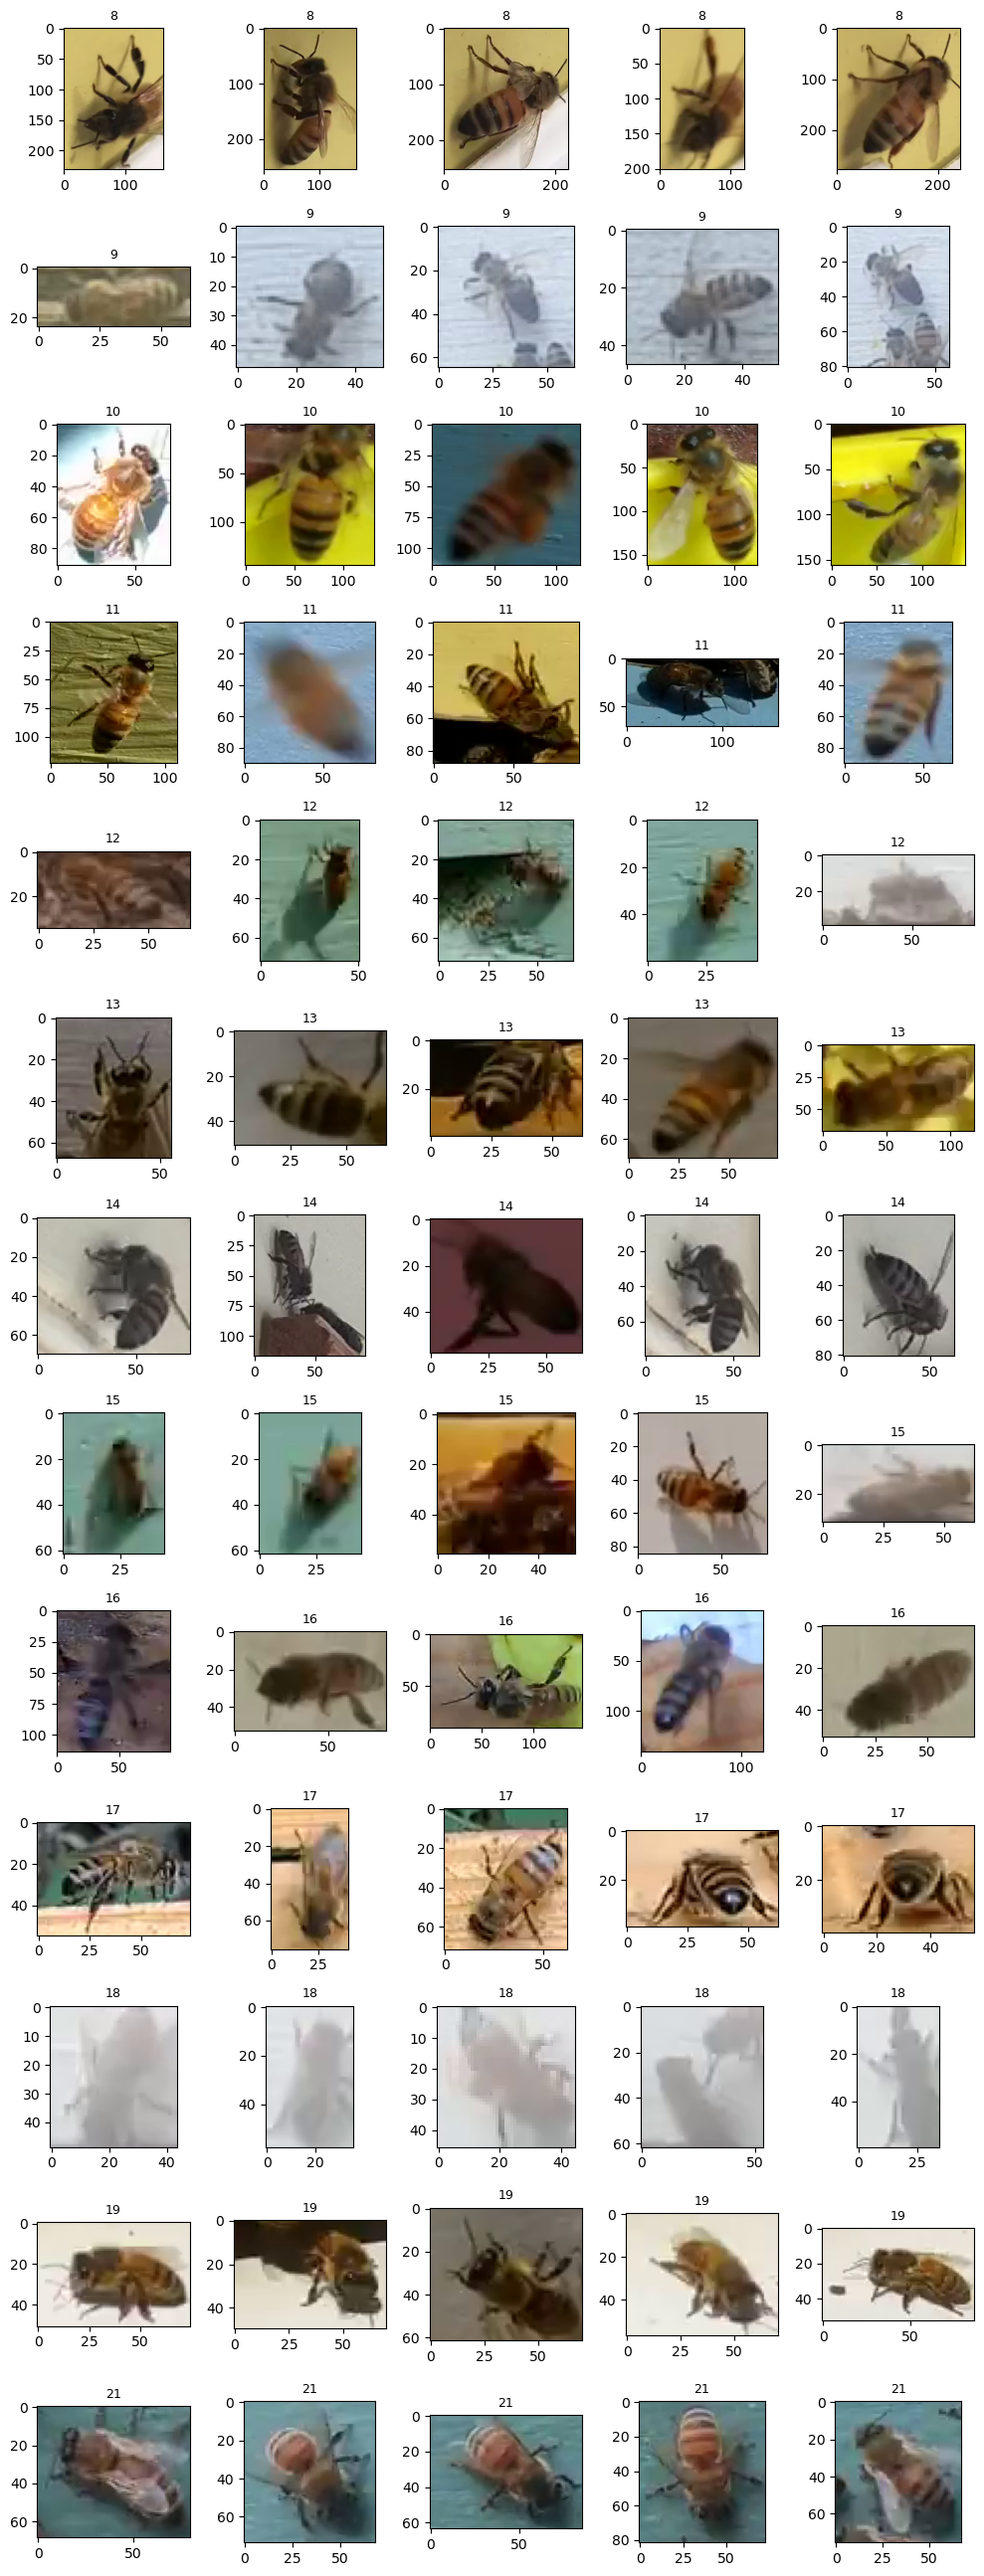

In [17]:
draw_category_images("hour")

In [20]:
tmp = honey_bee_df.groupby(['subspecies'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,subspecies,year,Images
0,-1,2018,428
1,1 Mixed local stock 2,2018,472
2,Carniolan honey bee,2018,501
3,Italian honey bee,2018,3008
4,Russian honey bee,2018,527
5,VSH Italian honey bee,2018,199
6,Western honey bee,2018,37


In [21]:
trace = go.Bar(
        x = df['subspecies'],
        y = df['Images'],
        marker=dict(color="Green"),
        text=df['subspecies']
    )
data = [trace]
    
layout = dict(title = 'Number of bees images per subspecies',
          xaxis = dict(title = 'Subspecies', showticklabels=True, tickangle=15), 
          yaxis = dict(title = 'Number of images'),
          hovermode = 'closest'
         )
fig = dict(data = data, layout = layout)
iplot(fig, filename='images-subspecies')

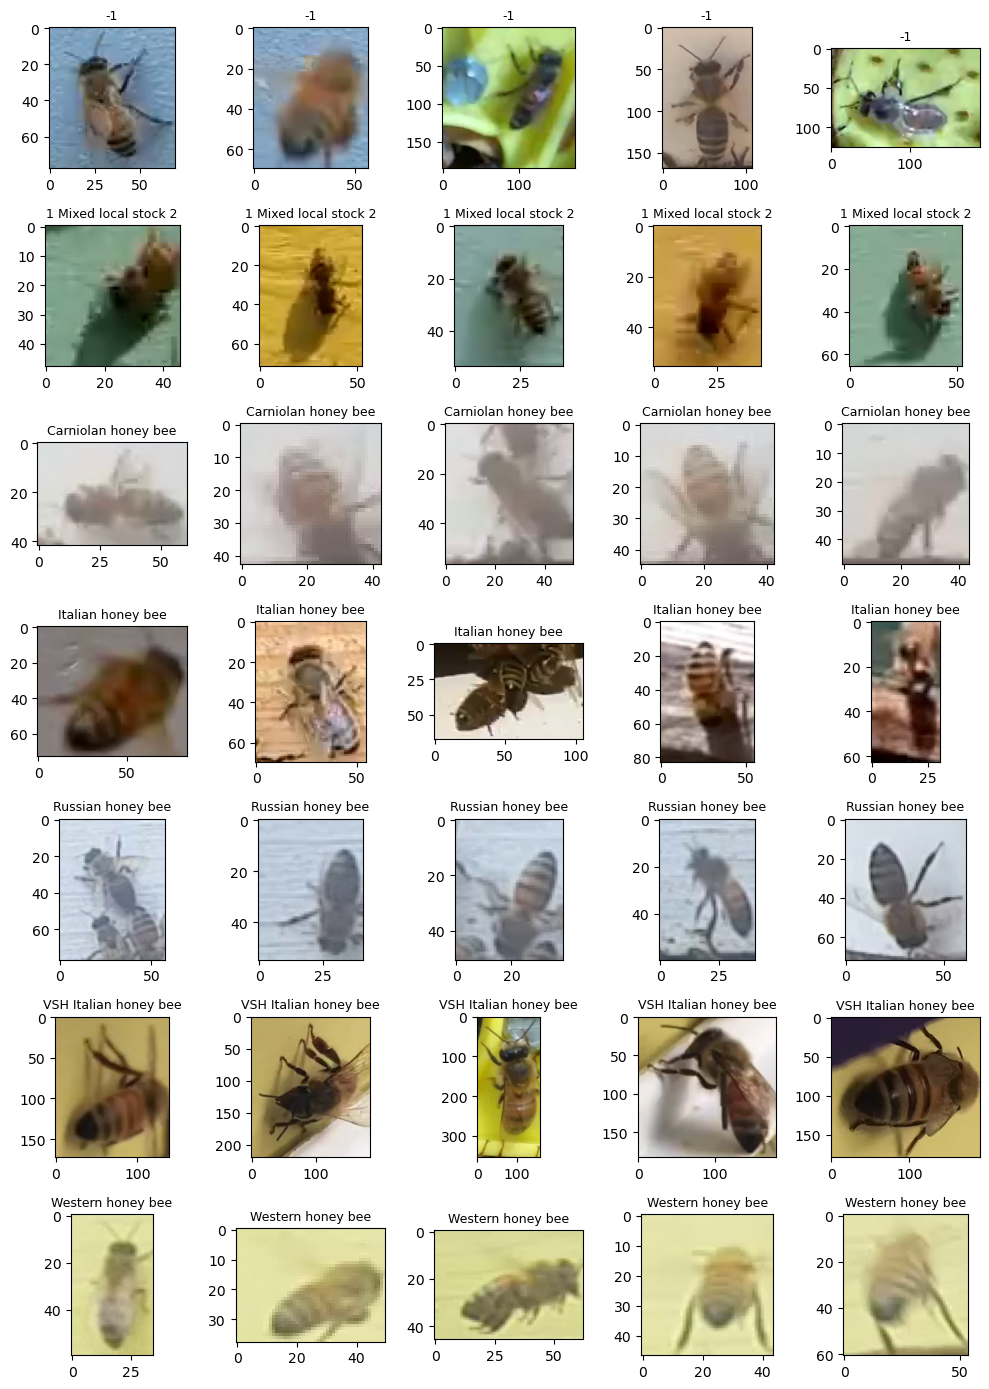

In [22]:
draw_category_images("subspecies")

In [23]:
train_df, test_df = train_test_split(honey_bee_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=honey_bee_df['subspecies'])

In [24]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df['subspecies'])

In [25]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [26]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [27]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [28]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

In [29]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 7)                 280007    
                                                                 
Total params: 282775 (1.08 MB)
Trainable params: 282775 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [32]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [33]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/5


C:\Users\gundm\AppData\Local\Temp\ipykernel_24680\3007739634.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 12s 113ms/step - loss: 0.9538 - accuracy: 0.6945 - val_loss: 0.7129 - val_accuracy: 0.7476
Epoch 2/5
103/103 [==============================] - 13s 125ms/step - loss: 0.6767 - accuracy: 0.7585 - val_loss: 0.5900 - val_accuracy: 0.7717
Epoch 3/5
103/103 [==============================] - 12s 114ms/step - loss: 0.5883 - accuracy: 0.7773 - val_loss: 0.5412 - val_accuracy: 0.7886
Epoch 4/5
103/103 [==============================] - 11s 110ms/step - loss: 0.5249 - accuracy: 0.8002 - val_loss: 0.5405 - val_accuracy: 0.8068
Epoch 5/5
103/103 [==============================] - 12s 112ms/step - loss: 0.4940 - accuracy: 0.7981 - val_loss: 0.5076 - val_accuracy: 0.8080


In [34]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model1)

In [35]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4900418519973755
Test accuracy: 0.8067632913589478


In [36]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [37]:
test_accuracy_report(model1)

33/33 [==============================] - 1s 16ms/step
                       precision    recall  f1-score   support

                   -1       0.70      0.52      0.60        86
1 Mixed local stock 2       0.47      0.53      0.50        94
  Carniolan honey bee       0.89      0.99      0.94       100
    Italian honey bee       0.85      0.87      0.86       602
    Russian honey bee       0.89      0.97      0.93       106
VSH Italian honey bee       0.70      0.17      0.28        40
    Western honey bee       1.00      0.86      0.92         7

             accuracy                           0.81      1035
            macro avg       0.79      0.70      0.72      1035
         weighted avg       0.80      0.81      0.80      1035

Loss function: 0.4900418519973755, accuracy: 0.8067632913589478


In [38]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                      

In [40]:
train_model2  = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10


C:\Users\gundm\AppData\Local\Temp\ipykernel_24680\2538114789.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 14s 127ms/step - loss: 1.2702 - accuracy: 0.6050 - val_loss: 0.8962 - val_accuracy: 0.7210
Epoch 2/10
103/103 [==============================] - 13s 123ms/step - loss: 0.7388 - accuracy: 0.7449 - val_loss: 0.6842 - val_accuracy: 0.7403
Epoch 3/10
103/103 [==============================] - 14s 137ms/step - loss: 0.5580 - accuracy: 0.7824 - val_loss: 0.6214 - val_accuracy: 0.7536
Epoch 4/10
103/103 [==============================] - 13s 127ms/step - loss: 0.4739 - accuracy: 0.8123 - val_loss: 0.4314 - val_accuracy: 0.8249
Epoch 5/10
103/103 [==============================] - 13s 123ms/step - loss: 0.4024 - accuracy: 0.8341 - val_loss: 0.4316 - val_accuracy: 0.8273
Epoch 6/10
103/103 [==============================] - 12s 120ms/step - loss: 0.3710 - accuracy: 0.8441 - val_loss: 0.4068 - val_accuracy: 0.8285
Epoch 7/10
103/103 [==============================] - 13s 123ms/step - loss: 0.3784 - accuracy: 0.8501 - val_loss: 0.3449 - val_accuracy: 0.8

In [41]:
plot_accuracy_and_loss(train_model2)

In [42]:
test_accuracy_report(model2)

33/33 [==============================] - 1s 16ms/step
                       precision    recall  f1-score   support

                   -1       0.95      0.70      0.81        86
1 Mixed local stock 2       0.50      0.74      0.60        94
  Carniolan honey bee       0.74      1.00      0.85       100
    Italian honey bee       0.93      0.85      0.89       602
    Russian honey bee       0.94      0.95      0.94       106
VSH Italian honey bee       0.74      0.65      0.69        40
    Western honey bee       0.70      1.00      0.82         7

             accuracy                           0.84      1035
            macro avg       0.79      0.84      0.80      1035
         weighted avg       0.87      0.84      0.85      1035

Loss function: 0.4228495955467224, accuracy: 0.843478262424469


In [43]:
annealer3 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper3 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [44]:
model3=Sequential()
model3.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model3.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(y_train.columns.size, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                      

In [46]:
train_model3  = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper3, checkpointer3, annealer3])

Epoch 1/50


C:\Users\gundm\AppData\Local\Temp\ipykernel_24680\2443815439.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 14s 126ms/step - loss: 1.0849 - accuracy: 0.6503 - val_loss: 0.6991 - val_accuracy: 0.7391 - lr: 7.7831e-04
Epoch 2/50
103/103 [==============================] - 13s 124ms/step - loss: 0.5886 - accuracy: 0.7779 - val_loss: 0.7808 - val_accuracy: 0.7488 - lr: 7.7442e-04
Epoch 3/50
103/103 [==============================] - 13s 121ms/step - loss: 0.5067 - accuracy: 0.8051 - val_loss: 0.4544 - val_accuracy: 0.8176 - lr: 7.7055e-04
Epoch 4/50
103/103 [==============================] - 13s 125ms/step - loss: 0.4415 - accuracy: 0.8296 - val_loss: 0.5687 - val_accuracy: 0.7995 - lr: 7.6670e-04
Epoch 5/50
103/103 [==============================] - 18s 169ms/step - loss: 0.4122 - accuracy: 0.8335 - val_loss: 0.3895 - val_accuracy: 0.8442 - lr: 7.6286e-04
Epoch 6/50
103/103 [==============================] - 18s 173ms/step - loss: 0.3772 - accuracy: 0.8377 - val_loss: 0.3817 - val_accuracy: 0.8502 - lr: 7.5905e-04
Epoch 7/50
103/103 [===================

103/103 [==============================] - 18s 178ms/step - loss: 0.2415 - accuracy: 0.8894 - val_loss: 0.2862 - val_accuracy: 0.8659 - lr: 6.8664e-04
Epoch 27/50
103/103 [==============================] - 18s 175ms/step - loss: 0.2440 - accuracy: 0.8927 - val_loss: 0.2736 - val_accuracy: 0.8841 - lr: 6.8321e-04
Epoch 28/50
103/103 [==============================] - 19s 179ms/step - loss: 0.2313 - accuracy: 0.9006 - val_loss: 0.2563 - val_accuracy: 0.8877 - lr: 6.7979e-04
Epoch 29/50
103/103 [==============================] - 19s 180ms/step - loss: 0.2251 - accuracy: 0.9051 - val_loss: 0.2504 - val_accuracy: 0.8744 - lr: 6.7639e-04
Epoch 30/50
103/103 [==============================] - 19s 180ms/step - loss: 0.2538 - accuracy: 0.8939 - val_loss: 0.2129 - val_accuracy: 0.9046 - lr: 6.7301e-04
Epoch 31/50
103/103 [==============================] - 19s 181ms/step - loss: 0.2157 - accuracy: 0.9084 - val_loss: 0.2287 - val_accuracy: 0.8841 - lr: 6.6965e-04
Epoch 32/50
103/103 [=============

In [47]:
plot_accuracy_and_loss(train_model3)

In [48]:
test_accuracy_report(model3)

33/33 [==============================] - 1s 22ms/step
                       precision    recall  f1-score   support

                   -1       1.00      0.76      0.86        86
1 Mixed local stock 2       0.59      0.69      0.64        94
  Carniolan honey bee       0.96      0.99      0.98       100
    Italian honey bee       0.92      0.93      0.92       602
    Russian honey bee       0.91      0.99      0.95       106
VSH Italian honey bee       1.00      0.78      0.87        40
    Western honey bee       1.00      1.00      1.00         7

             accuracy                           0.90      1035
            macro avg       0.91      0.88      0.89      1035
         weighted avg       0.91      0.90      0.90      1035

Loss function: 0.2452375888824463, accuracy: 0.8975845575332642


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(np.argmax(y_test, axis=1), y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.columns, yticklabels=y_test.columns)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Assuming model1, model2, and model3 are instances of your trained models
evaluate_model(model1, X_test, y_test)
evaluate_model(model2, X_test, y_test)
evaluate_model(model3, X_test, y_test)